# RP IM Sync

### Imports

In [1]:
# Python standard library
import os
import sys
import csv

# Scipy, etc.
import scipy.interpolate
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Program specific
PORE_STATS_BASE_DIRECTORY = os.getcwd().replace('notebooks', '')
sys.path.append(PORE_STATS_BASE_DIRECTORY + '/pore_stats/rp/')
sys.path.append(PORE_STATS_BASE_DIRECTORY + '/pore_stats/oi/')
import resistive_pulse as rp
import rp_file
import optical_imaging as oi
import oi_file

# Jupyter
from IPython.display import HTML

### Open files and preprocess data

##### Set file info

In [2]:
date = '/8-23-2017'
particle = '/293-T'
chip = '/15-30-15_4'
file_index = '3'

base_directory = '/home/prestonh/Desktop/Research/cancer_cells/data/'+date+particle+chip

##### Open RP

In [4]:
rp_fps = 250000.


# RP data files
rp_data_file_directory = base_directory + '/rp/bts/'
rp_data_file_name = 'test_rp_'+file_index+'.bts'
rp_data_file_path = rp_data_file_directory + rp_data_file_name

rp_data = rp_file.get_data(rp_data_file_path)



# RP event files
rp_events_file_directory = base_directory + '/rp/events/'
rp_events_file_name = 'test_rp_' + file_index + '_events.json'
rp_events_file_path = rp_events_file_directory + rp_events_file_name

rp_events = rp_file.open_event_file_json(rp_events_file_path)

##### Open OI

In [5]:
oi_res_x = 512
oi_res_y = 288
oi_fps = 125000.
oi_exp = .5

# OI data files
oi_vid_file_directory = base_directory + '/oi/bin/'
oi_vid_file_name = 'test_camera_' + file_index
oi_vid_file_path = oi_vid_file_directory + oi_vid_file_name

oi_vid = oi_file.Video(oi_vid_file_path, oi_res_x, oi_res_y, oi_fps, oi_exp)


# OI event files
oi_events_file_directory = base_directory + '/oi/events/'
oi_events_file_name = 'test_camera_' + file_index + '_events.json'
oi_events_file_path = oi_events_file_directory + oi_events_file_name

oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats//pore_stats/oi/optical_imaging.py:75: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


In [6]:
print "#rp: ", len(rp_events)
print "#oi: ", len(oi_events)

#rp:  33
#oi:  1956


##### Open output file

In [7]:
output_file_directory = oi_vid_file_directory.replace('oi/bin/','')
output_file_name = oi_vid_file_name.replace('camera_','') + '_pos_amp'
output_file_path = output_file_directory + output_file_name
print output_file_path

/home/prestonh/Desktop/Research/cancer_cells/data//8-23-2017/293-T/15-30-15_4/test_3_pos_amp


##### Create stage

[-0.  1.]


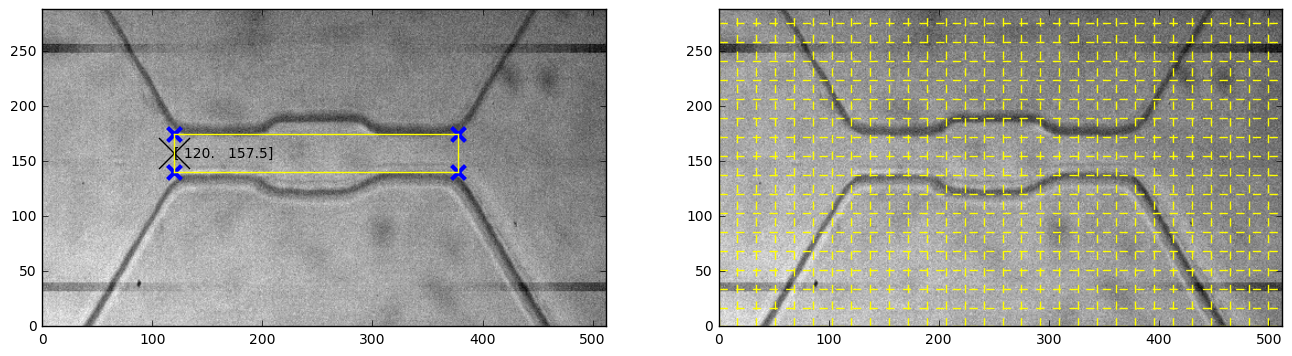

In [9]:
reload(oi)
template_index = 0
template_frame = oi_vid.get_frame(template_index)
c0 = [120, 140]
c1 = [120, 175]
c2 = [378, 175] 
c3 = [378, 140]
stage = oi.Stage(template_frame, c0, c1, c2, c3)
stage._length_microns = 150
stage.plot_stage()

##### Filter events that do not enter and exit channel

In [10]:
# Get channel enter/exit time
for event in oi_events:
    event.get_channel_enter_exit_tf(stage)

print 'length before:', len(oi_events)
oi_events = [event for event in oi_events if event._channel_enter_tf != None and event._channel_exit_tf != None]
print 'length after:', len(oi_events)

length before: 1956
length after: 1956


##### Sort events by translocation time

In [11]:
def rp_sort(event):
    return np.mean(event._data[:,0])

def oi_sort(event):
    return (event._channel_enter_tf+event._channel_exit_tf)/2.

rp_events = sorted(rp_events, key = rp_sort)
oi_events = sorted(oi_events, key = oi_sort)



### Synchronize events

In [12]:
rp_times = np.array([event._data[:,0].mean() for event in rp_events]).reshape(-1,1)

oi_times = np.array([(event._channel_enter_tf+event._channel_exit_tf)/2./oi_fps for event in oi_events]).reshape(-1,1)

[ 2.671592]


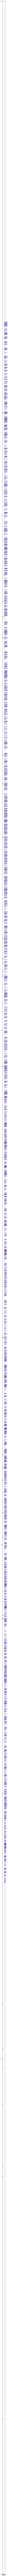

In [17]:
fig = plt.figure(figsize = (.5,500))

offset = rp_times[-1]-oi_times[-100]

print offset

plt.scatter([0 for i in range(rp_times.shape[0])], rp_times, color = 'red')
plt.scatter([1 for i in range(oi_times.shape[0])], oi_times+offset, color = 'blue')



y_lower = 4.25-oi_fps/oi_vid._total_frames
y_upper = 4.25

for i, event in enumerate(oi_events):
    plt.text(1.25, oi_times[i] + offset, str(i))

for i, event in enumerate(rp_events):
    plt.text(-.25, rp_times[i], str(i))

#plt.ylim(y_lower, y_upper)


plt.show()

##### $\epsilon$ filtering

In [31]:
epsilon_oi_remove_list = []
epsilon_rp_remove_list = []

epsilon = .001
for i, rp_time in enumerate(rp_times):
    diffs = []
    for j, oi_time in enumerate(oi_times):
        diffs.append(np.abs(rp_time - (oi_time + offset)))
        
    if np.min(diffs) >= epsilon:
        epsilon_rp_remove_list.append(i)
        
for i, oi_time in enumerate(oi_times):
    diffs = []
    for j, rp_time in enumerate(rp_times):
        diffs.append(np.abs(rp_time - (oi_time + offset)))
        
    if np.min(diffs) >= epsilon:
        epsilon_oi_remove_list.append(i)
        
print epsilon_rp_remove_list
print epsilon_oi_remove_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 29, 39, 45, 47, 55, 58, 59, 62, 63, 81, 86, 87, 89, 90, 93, 95, 97, 102, 103, 107, 108, 111, 112, 113, 118, 127, 129, 135, 142, 143, 145, 146, 149, 158]
[1, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23, 28, 31, 33, 38, 41, 42, 44, 45, 53, 54, 55, 73, 85, 86, 89, 93, 101, 119, 125, 126, 133, 138, 143, 144, 145, 146, 147]


##### Remove non-matches

In [36]:
rp_remove_list = epsilon_rp_remove_list + [94,80,43]
oi_remove_list = epsilon_oi_remove_list + [141,87,88,76,77,36,37]
rp_indices = [i for i in range(len(rp_events)) if i not in rp_remove_list]
oi_indices = [i for i in range(len(oi_events)) if i not in oi_remove_list]

In [37]:
rp_times = np.hstack((np.array([i for i in range(len(rp_events)) if i not in rp_remove_list]).reshape(-1,1),
                      np.array([rp_event._data[:,0].mean() for i, rp_event in enumerate(rp_events)\
                     if i not in rp_remove_list]).reshape(-1,1)))

#oi_times = np.array([(oi_event._channel_enter_tf + oi_event._channel_exit_tf)/(2.*fps) for i, oi_event in enumerate(oi_events)\
#                     if i not in oi_remove_list]).reshape(-1,1)

oi_times = np.hstack((np.array([i for i in range(len(oi_events)) if i not in oi_remove_list]).reshape(-1,1),
                      np.array([(1.*oi_event._channel_enter_tf)/(oi_fps) for i, oi_event in enumerate(oi_events)\
                     if i not in oi_remove_list]).reshape(-1,1)))
                      

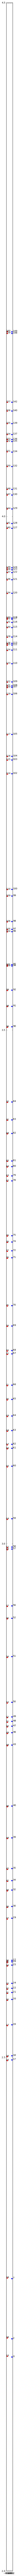

In [38]:
plt.close()
fig = plt.figure(figsize = (.5,200))


plt.scatter([0 for i in range(rp_times.shape[0])], rp_times[:,1], color = 'red')
plt.scatter([1 for i in range(oi_times.shape[0])], oi_times[:,1]+offset[0], color = 'blue')



y_lower = 0
y_upper = 4.25

for i in range(len(rp_times)):
    plt.text(-.25, rp_times[i,1], str(int(rp_times[i,0])))

for i in range(len(oi_times)):
    plt.text(1.25, oi_times[i,1] + offset, str(int(oi_times[i,0])))

    
plt.show()

##### Finally, remove

In [39]:
rp_events = [rp_events[i] for i in range(len(rp_events)) if i not in rp_remove_list]
oi_events = [oi_events[i] for i in range(len(oi_events)) if i not in oi_remove_list]

rp_times = [rp_event._data[:,0].mean() for rp_event in rp_events]
oi_times = [(oi_event._channel_enter_tf + oi_event._channel_exit_tf)/(2.*oi_fps) for oi_event in oi_events]

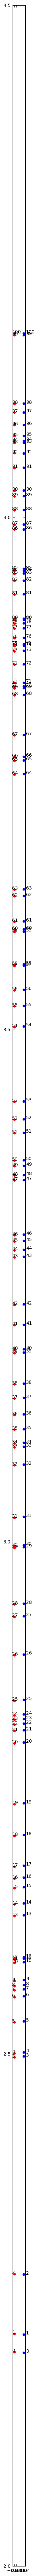

In [40]:
plt.close()
fig = plt.figure(figsize = (.5,100))

offset = rp_times[-1]-oi_times[-1]

plt.scatter([0 for i in range(len(rp_times))], rp_times, color = 'red')
plt.scatter([1 for i in range(len(oi_times))], oi_times+offset, color = 'blue')



y_lower = 0
y_upper = 4.25

for i in range(len(rp_times)):
    plt.text(-.25, rp_times[i], str(i))

for i in range(len(oi_times)):
    plt.text(1.25, oi_times[i] + offset, str(i))

    
plt.show()

##### Save paired events

In [41]:
print len(rp_events), len(oi_events)

rp_events_save_file_path = rp_events_file_path.split('.')[0]+'_sync.json'
oi_events_save_file_path = oi_events_file_path.split('.')[0]+'_sync.json'

print rp_events_save_file_path
print oi_events_save_file_path

101 101
/home/prestonh/Desktop/Research/cancer_cells/data//7-17-2017/293-T/15-30-15_1/rp/events/test_rp_0_events_sync.json
/home/prestonh/Desktop/Research/cancer_cells/data//7-17-2017/293-T/15-30-15_1/oi/events/test_camera_0_events_sync.json


In [42]:
rp_file.save_rp_events_json(rp_events_save_file_path, rp_events)
oi_file.save_oi_events_json(oi_events_save_file_path, oi_events)